In [1]:
import pandas as pd
import numpy as np
import json
import time

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [4]:
df_labels= 'data/data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'data/dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [5]:
df_labels['transcript_position'].astype(int)
print(df_labels[0:5])

           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0


In [6]:
datapoint_zero = []
datapoint_one = []
start = time.time()
for datapoint in data_list:
    for tId, tPos in datapoint.items():
        specific_transcript_id = tId
        for pos, seq in tPos.items():
            specific_transcript_position = int(pos)
            for _, bag in seq.items():
                measurements = bag
    filtered_label = df_labels[(df_labels['transcript_id'] == specific_transcript_id) & 
                    (df_labels['transcript_position'] == specific_transcript_position)]['label']
    if len(filtered_label) != 1:
        print(f"Anomaly with {specific_transcript_id} at {specific_transcript_position} position, found {len(filtered_label)} matches")
    if filtered_label.iloc[0] == 0:
        datapoint_zero.append(measurements)
    else:
        datapoint_one.append(measurements)
print(f"process took {time.time() - start :2f}")

process took 526.897865


Data Point 1:
  Mean Anomaly Score: 6.9413
  Max Anomaly Score: 13.4301
  Sublists with Anomaly Score > 11.25346449335083: 7, 0.03910614525139665
  Std Dev of Anomaly Scores: 2.1561


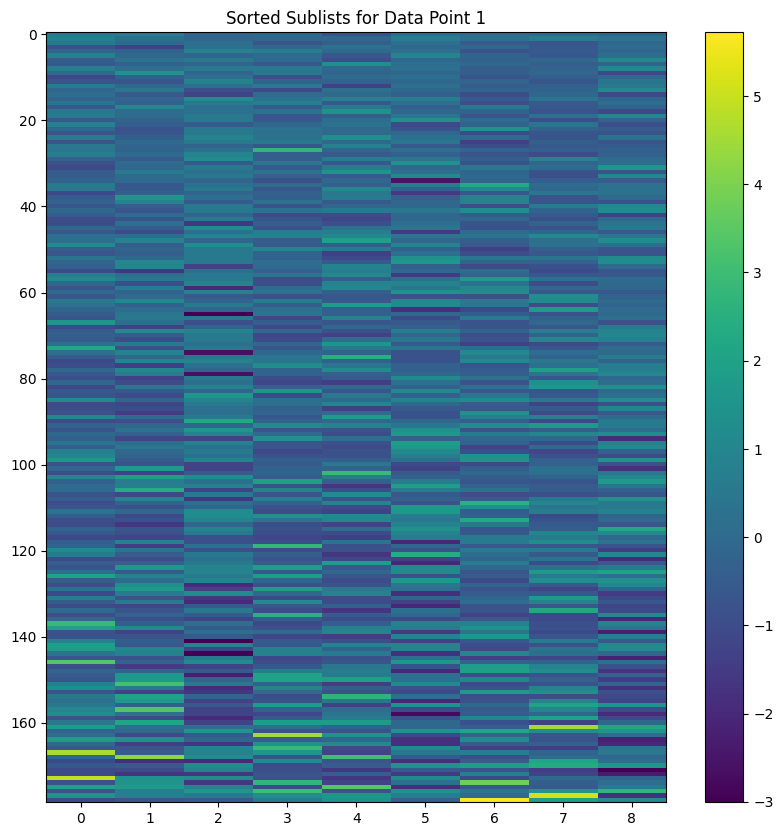

Data Point 2:
  Mean Anomaly Score: 6.8616
  Max Anomaly Score: 16.0227
  Sublists with Anomaly Score > 11.495958729381192: 2, 0.03333333333333333
  Std Dev of Anomaly Scores: 2.3172


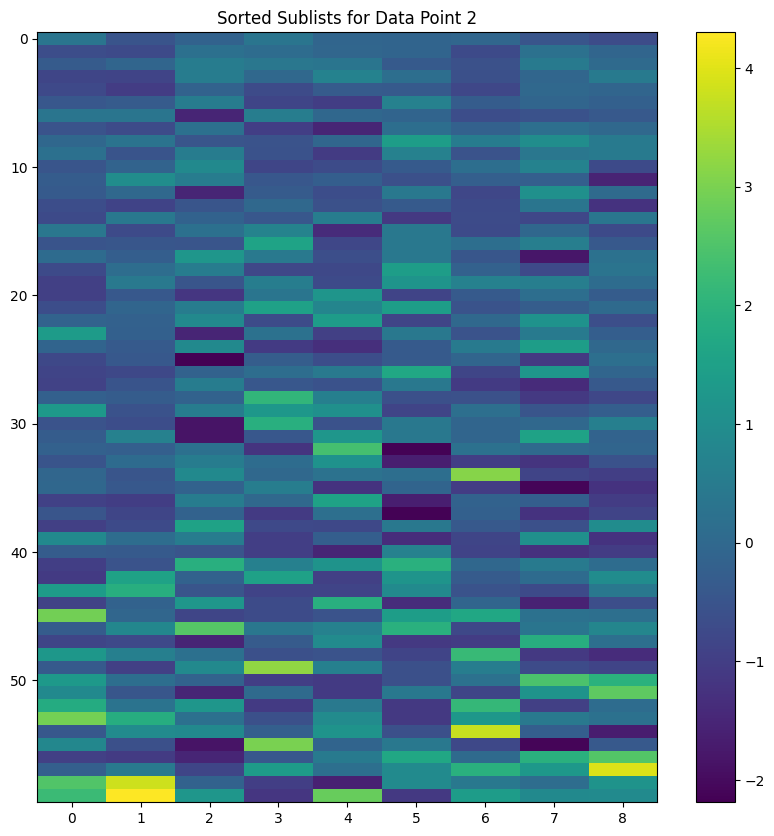

Data Point 3:
  Mean Anomaly Score: 6.6029
  Max Anomaly Score: 13.6601
  Sublists with Anomaly Score > 12.001184211101396: 5, 0.08771929824561403
  Std Dev of Anomaly Scores: 2.6992


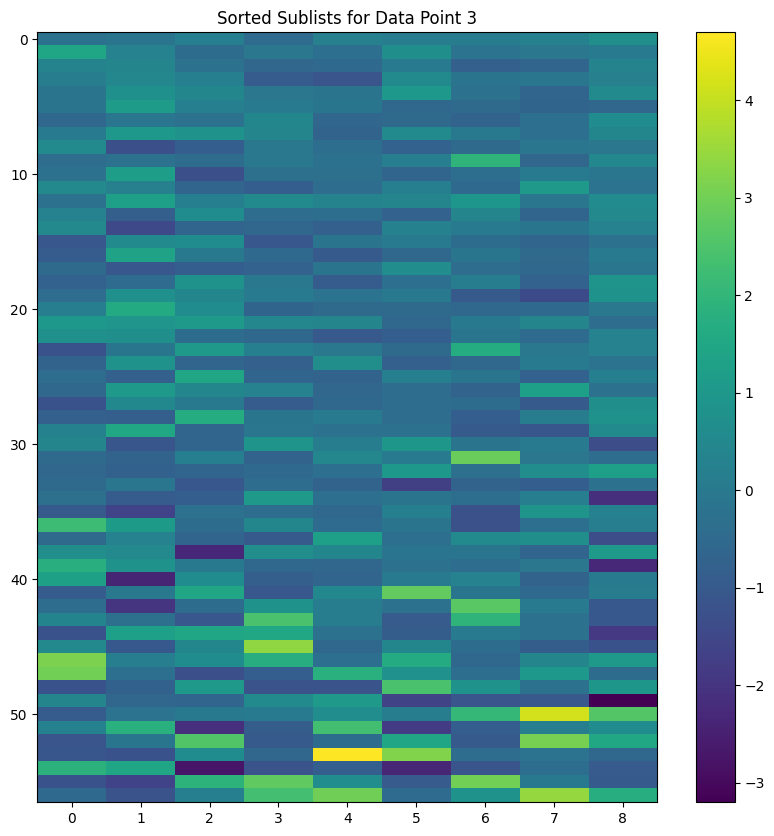

Data Point 4:
  Mean Anomaly Score: 6.9576
  Max Anomaly Score: 15.5284
  Sublists with Anomaly Score > 10.837418807556189: 1, 0.022727272727272728
  Std Dev of Anomaly Scores: 1.9399


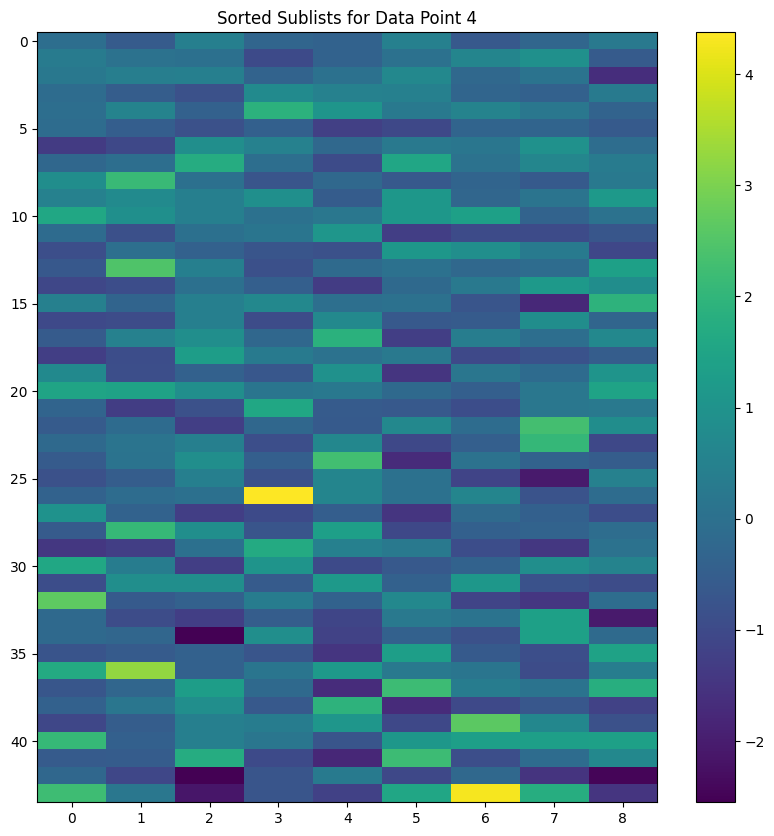

Data Point 5:
  Mean Anomaly Score: 7.1774
  Max Anomaly Score: 13.1173
  Sublists with Anomaly Score > 11.431663730136902: 3, 0.0625
  Std Dev of Anomaly Scores: 2.1271


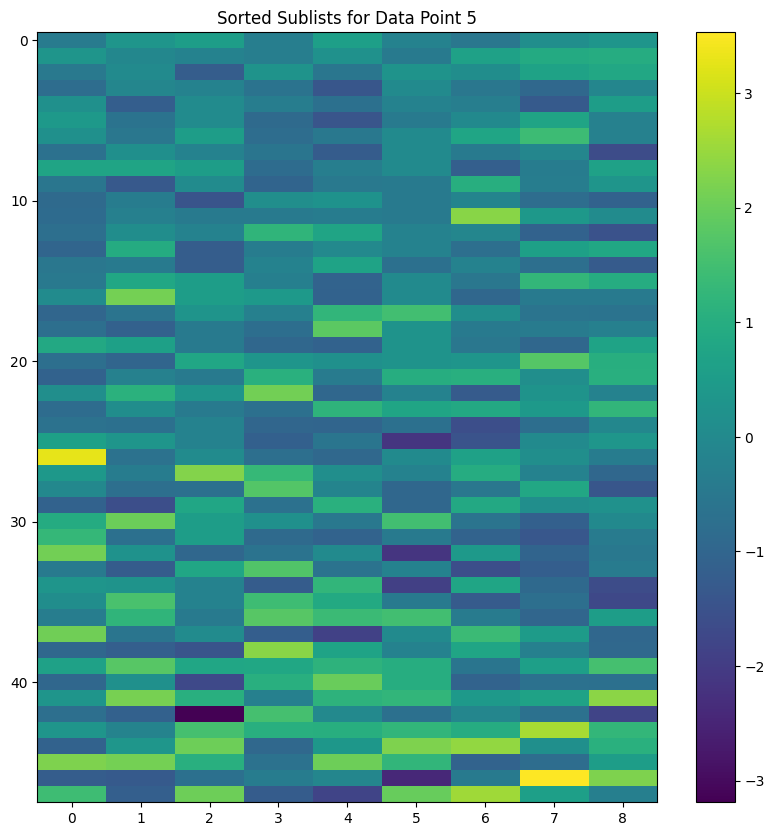

In [37]:
from scipy.stats import zscore

# Threshold for identifying highly anomalous sublists
anomaly_threshold = 3

# Calculate Z-scores for each sublist instead of comparing to a fixed ideal row
for i, dp in enumerate(datapoint_one[0:5]):  # Adjust range or dataset accordingly
    dp_array = np.array(dp)  # dp is the x-length list of length-9 sublists
    # if len(dp_array) < 100:
    #     continue
    
    # Normalization for each length-9 sublist
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    
    # Calculate Z-scores for each feature in the sublist
    z_scores = zscore(dp_array, axis=0)

    # Now calculate the Z-score-based anomaly score for each length-9 sublist
    anomaly_scores = []
    for row in z_scores:
        # Aggregate the absolute Z-scores to get a single anomaly score for each sublist
        anomaly_score = np.sum(np.abs(row))  # Sum of absolute Z-scores
        anomaly_scores.append((anomaly_score, row))  # Store the score along with the sublist
    
    # Sort the x-length list (dp_array) based on anomaly scores
    sorted_rows = sorted(anomaly_scores, key=lambda x: x[0])

    # Extract the sorted sublists
    sorted_sublists = np.array([sublist for score, sublist in sorted_rows])

    # Calculate anomaly metrics:
    anomaly_scores_only = [score for score, sublist in sorted_rows]
    
    # 1. Mean anomaly score for the entire data point
    mean_anomaly_score = np.mean(anomaly_scores_only)
    
    # 2. Maximum anomaly score for the most anomalous sublist
    max_anomaly_score = np.max(anomaly_scores_only)
    
    # 3. Count how many sublists exceed the anomaly threshold
    
    # 4. Standard deviation of the anomaly scores
    std_anomaly_score = np.std(anomaly_scores_only)

    anomaly_threshold = mean_anomaly_score + 2 * std_anomaly_score
    highly_anomalous_count = np.sum(np.array(anomaly_scores_only) > anomaly_threshold)
    
    # Print anomaly metrics for this data point
    print(f"Data Point {i+1}:")
    print(f"  Mean Anomaly Score: {mean_anomaly_score:.4f}")
    print(f"  Max Anomaly Score: {max_anomaly_score:.4f}")
    print(f"  Sublists with Anomaly Score > {anomaly_threshold}: {highly_anomalous_count}, {highly_anomalous_count/len(dp_array)}")
    print(f"  Std Dev of Anomaly Scores: {std_anomaly_score:.4f}")
    
    # Visualize all sorted sublists as a combined heatmap
    plt.figure(figsize=(10, 10))  # Adjust figure size based on number of sublists
    plt.imshow(sorted_sublists, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Sorted Sublists for Data Point {i+1}')
    plt.colorbar()
    plt.show()


Data Point 1:
  Mean Anomaly Score: 6.7922
  Max Anomaly Score: 18.4483
  Sublists with Anomaly Score > 11.239917925310799: 8, 0.043243243243243246
  Std Dev of Anomaly Scores: 2.2239


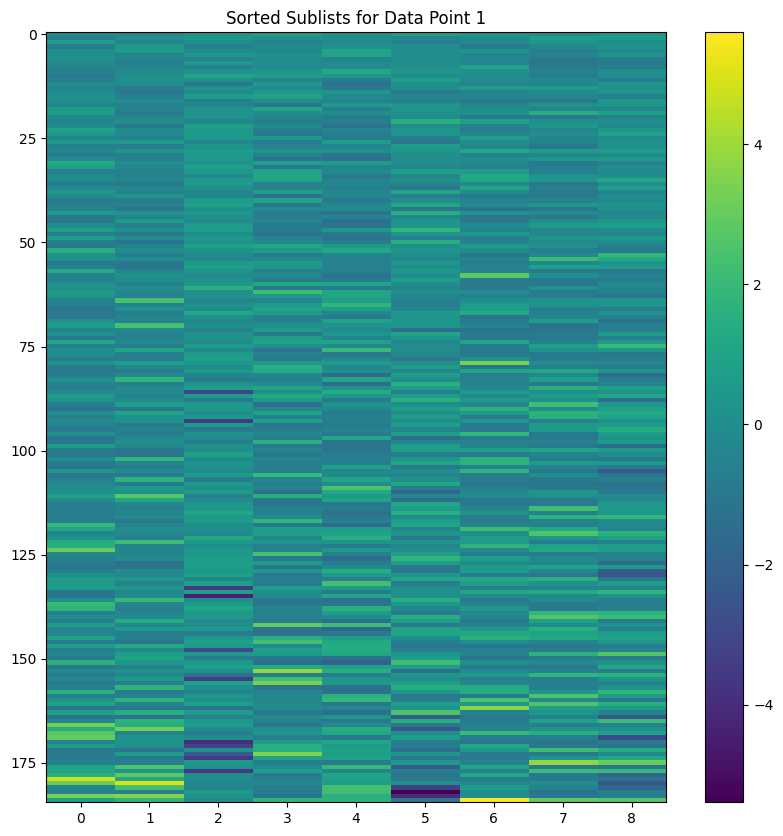

Data Point 2:
  Mean Anomaly Score: 6.4749
  Max Anomaly Score: 13.4887
  Sublists with Anomaly Score > 10.785988709668121: 8, 0.046511627906976744
  Std Dev of Anomaly Scores: 2.1556


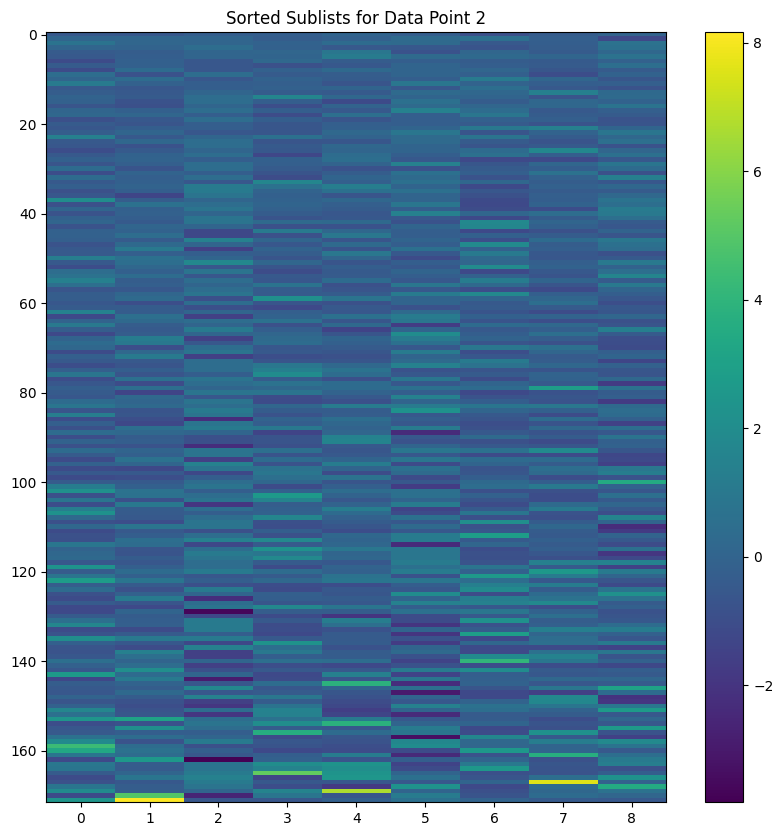

Data Point 3:
  Mean Anomaly Score: 6.5655
  Max Anomaly Score: 16.5624
  Sublists with Anomaly Score > 11.769149659259217: 10, 0.05405405405405406
  Std Dev of Anomaly Scores: 2.6018


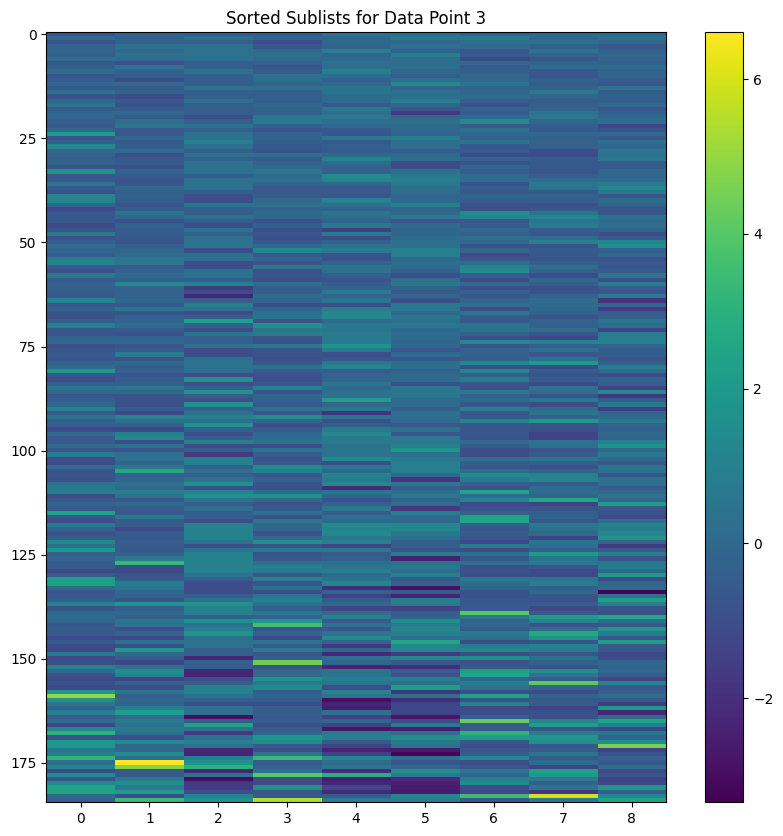

Data Point 4:
  Mean Anomaly Score: 6.5828
  Max Anomaly Score: 20.7292
  Sublists with Anomaly Score > 11.148662428540046: 9, 0.045
  Std Dev of Anomaly Scores: 2.2829


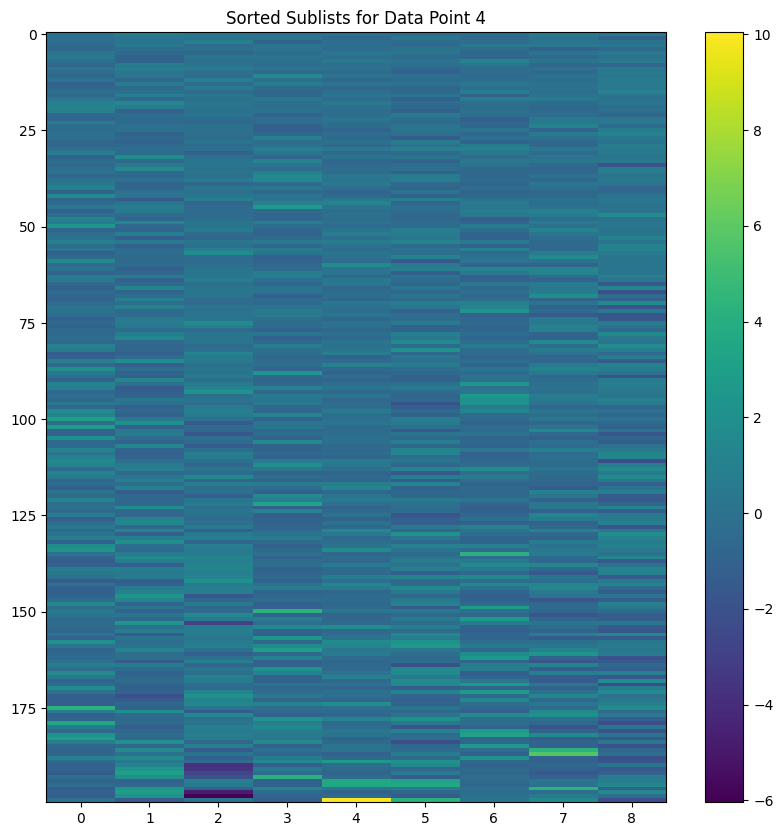

Data Point 5:
  Mean Anomaly Score: 6.5012
  Max Anomaly Score: 19.3254
  Sublists with Anomaly Score > 11.367936326676523: 7, 0.03535353535353535
  Std Dev of Anomaly Scores: 2.4334


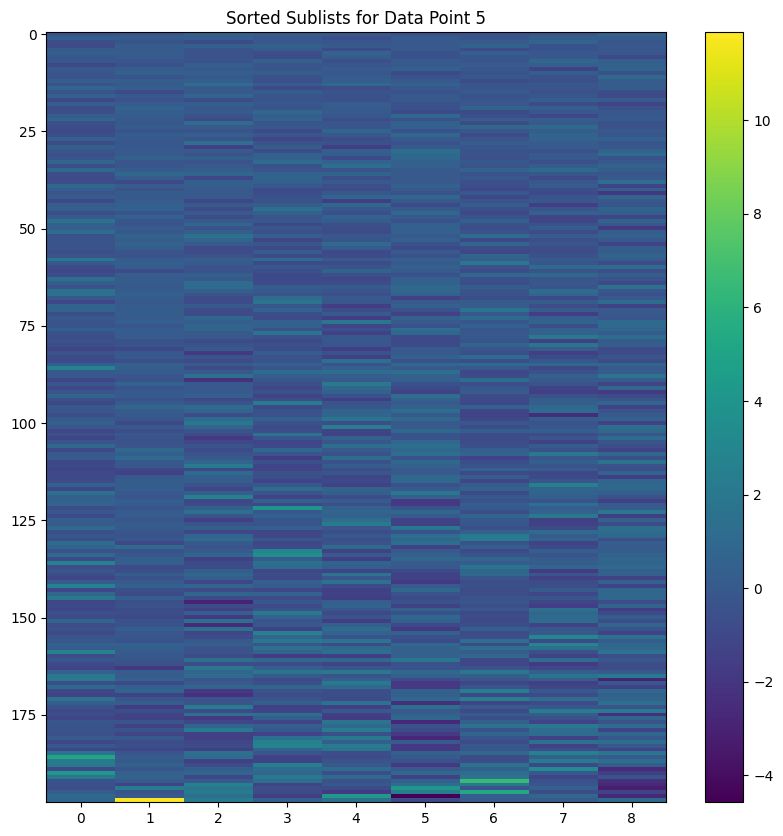

In [36]:
from scipy.stats import zscore

# Threshold for identifying highly anomalous sublists
anomaly_threshold = 3

# Calculate Z-scores for each sublist instead of comparing to a fixed ideal row
for i, dp in enumerate(datapoint_zero[0:5]):  # Adjust range or dataset accordingly
    dp_array = np.array(dp)  # dp is the x-length list of length-9 sublists
    if len(dp_array) < 100:
        continue
    
    # Normalization for each length-9 sublist
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    
    # Calculate Z-scores for each feature in the sublist
    z_scores = zscore(dp_array, axis=0)

    # Now calculate the Z-score-based anomaly score for each length-9 sublist
    anomaly_scores = []
    for row in z_scores:
        # Aggregate the absolute Z-scores to get a single anomaly score for each sublist
        anomaly_score = np.sum(np.abs(row))  # Sum of absolute Z-scores
        anomaly_scores.append((anomaly_score, row))  # Store the score along with the sublist
    
    # Sort the x-length list (dp_array) based on anomaly scores
    sorted_rows = sorted(anomaly_scores, key=lambda x: x[0])

    # Extract the sorted sublists
    sorted_sublists = np.array([sublist for score, sublist in sorted_rows])

    # Calculate anomaly metrics:
    anomaly_scores_only = [score for score, sublist in sorted_rows]
    
    # 1. Mean anomaly score for the entire data point
    mean_anomaly_score = np.mean(anomaly_scores_only)
    
    # 2. Maximum anomaly score for the most anomalous sublist
    max_anomaly_score = np.max(anomaly_scores_only)
    
    # 3. Count how many sublists exceed the anomaly threshold
    anomaly_threshold = mean_anomaly_score
    highly_anomalous_count = np.sum(np.array(anomaly_scores_only) > anomaly_threshold)
    
    # 4. Standard deviation of the anomaly scores
    std_anomaly_score = np.std(anomaly_scores_only)

    anomaly_threshold = mean_anomaly_score + 2 * std_anomaly_score
    highly_anomalous_count = np.sum(np.array(anomaly_scores_only) > anomaly_threshold)
    
    # Print anomaly metrics for this data point
    print(f"Data Point {i+1}:")
    print(f"  Mean Anomaly Score: {mean_anomaly_score:.4f}")
    print(f"  Max Anomaly Score: {max_anomaly_score:.4f}")
    print(f"  Sublists with Anomaly Score > {anomaly_threshold}: {highly_anomalous_count}, {highly_anomalous_count/len(dp_array)}")
    print(f"  Std Dev of Anomaly Scores: {std_anomaly_score:.4f}")
    
    # Visualize all sorted sublists as a combined heatmap
    plt.figure(figsize=(10, 10))  # Adjust figure size based on number of sublists
    plt.imshow(sorted_sublists, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Sorted Sublists for Data Point {i+1}')
    plt.colorbar()
    plt.show()


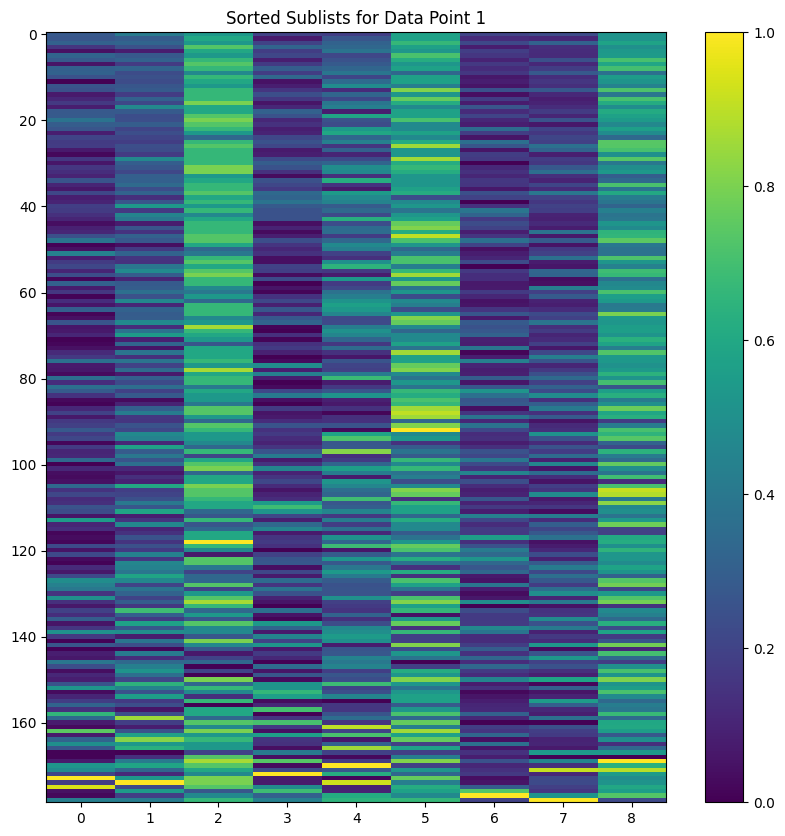

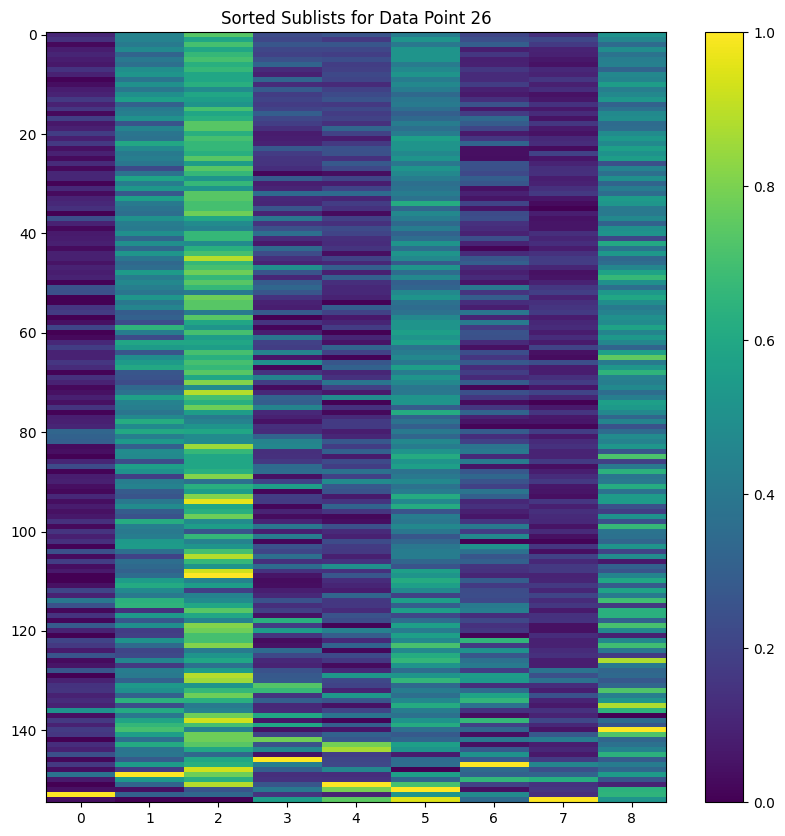

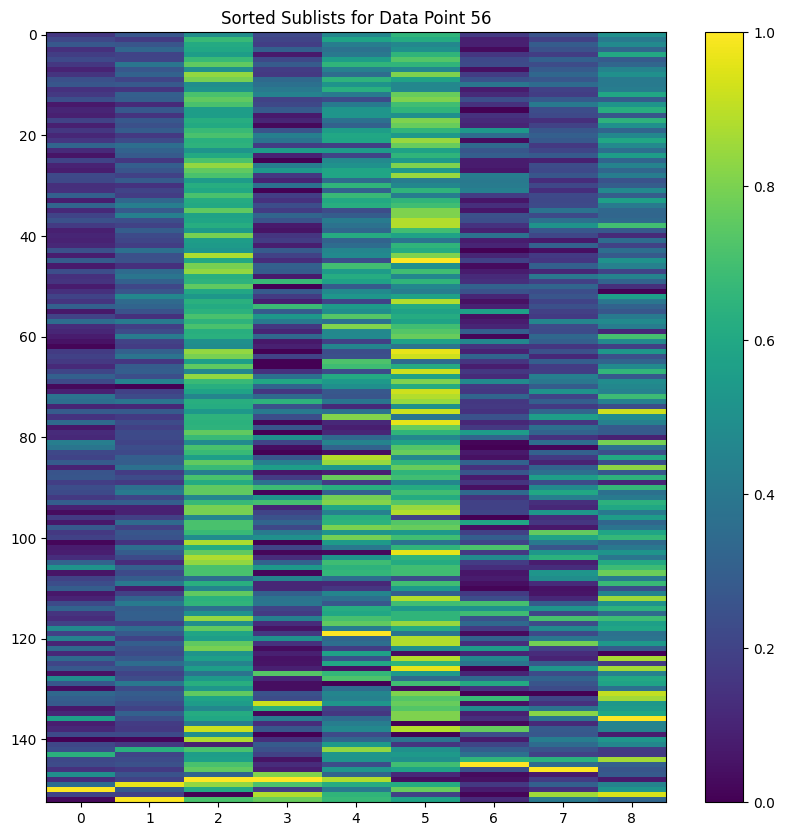

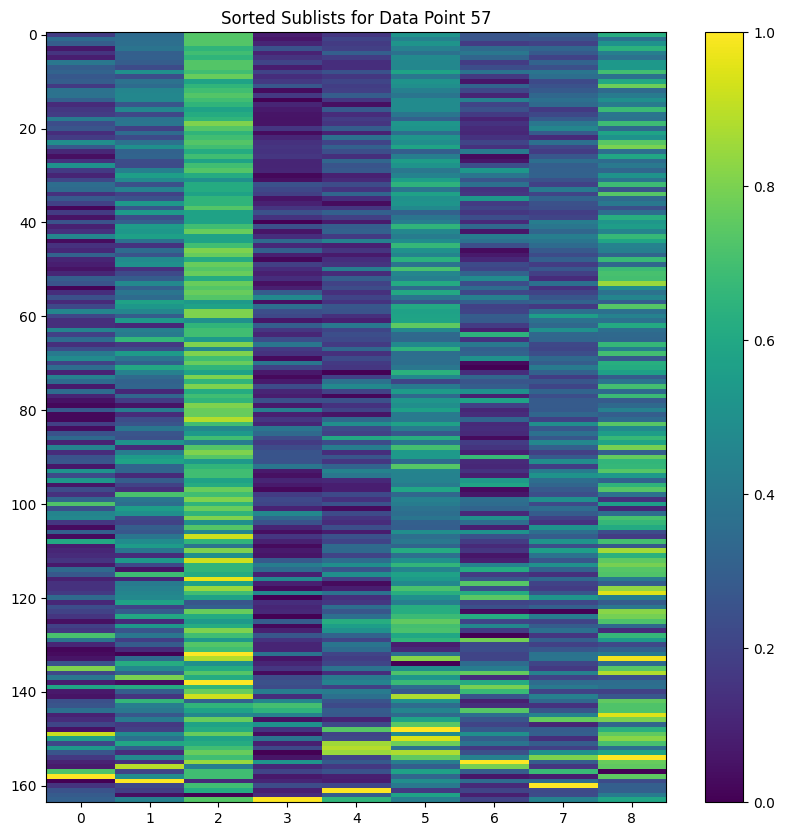

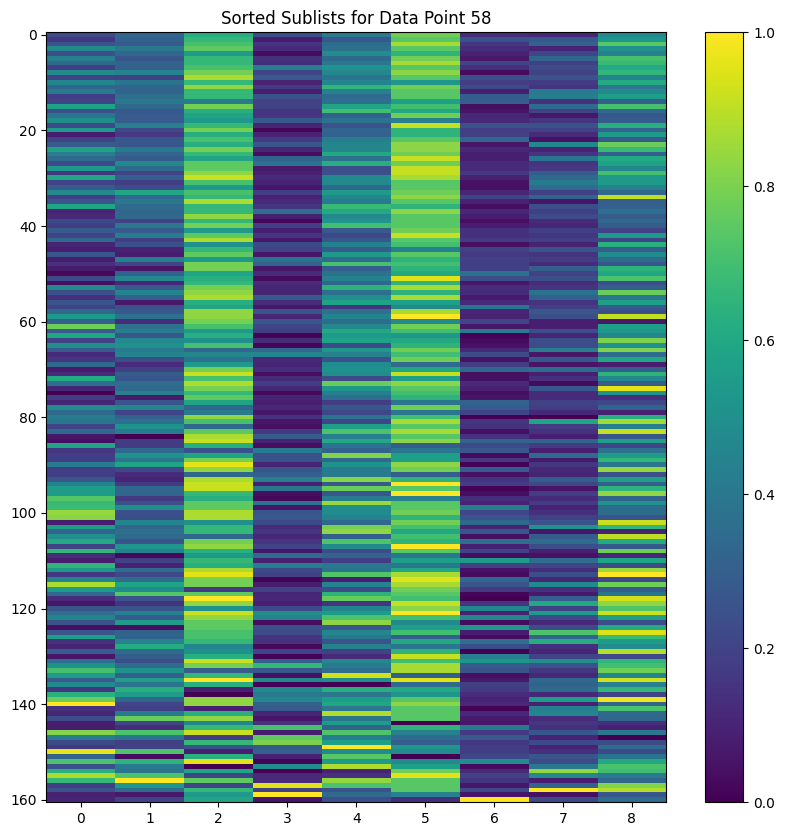

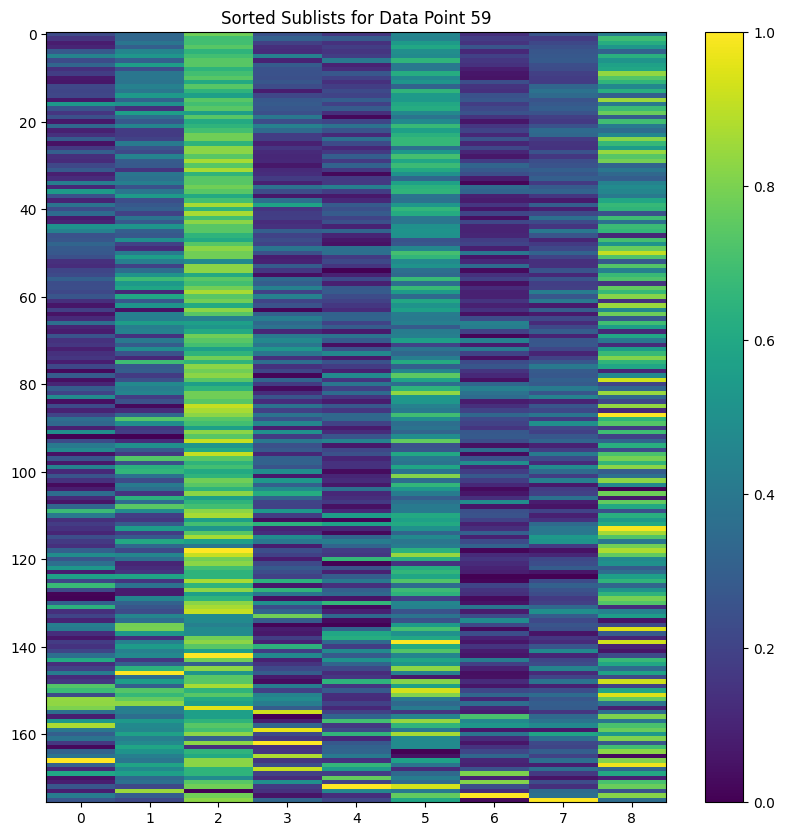

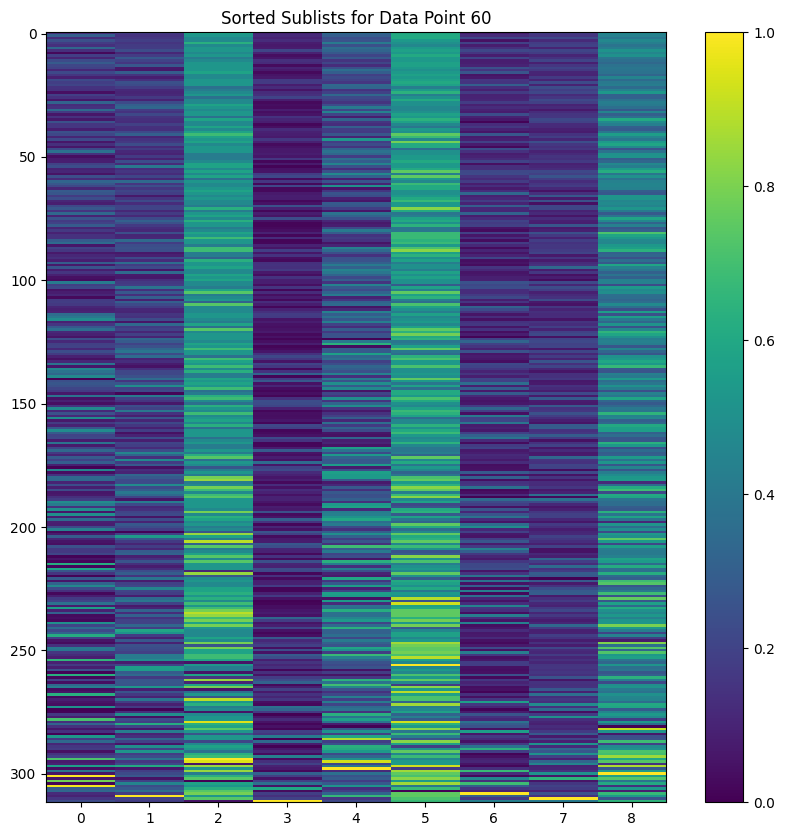

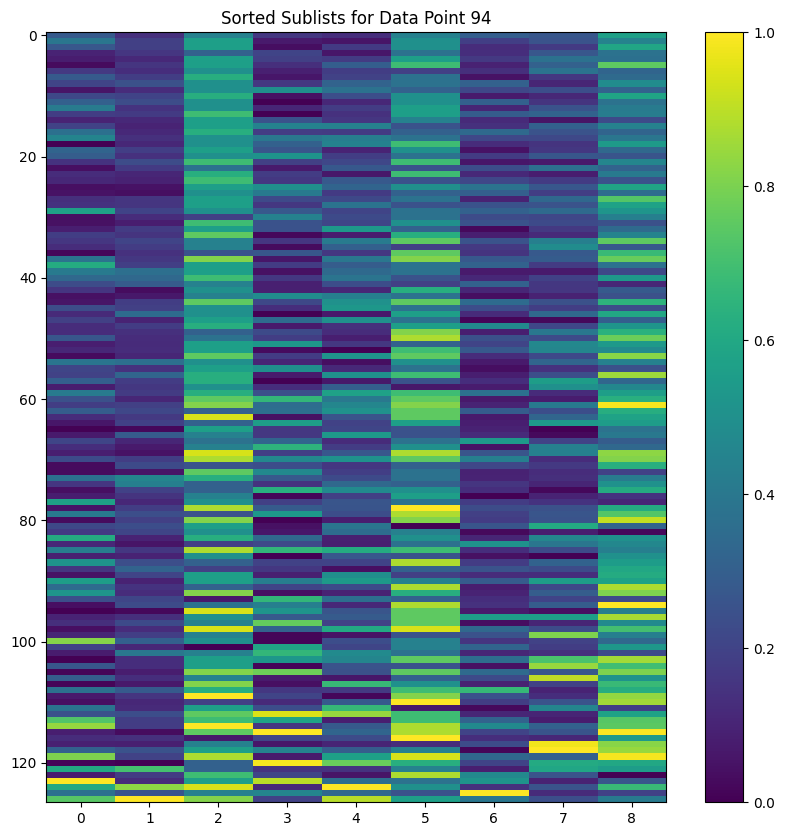

In [38]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Calculate Mahalanobis distance for each sublist instead of using Euclidean distance
for i, dp in enumerate(datapoint_one[0:100]):  # Adjust range or dataset accordingly
    dp_array = np.array(dp)  # dp is the x-length list of length-9 sublists
    if len(dp_array) < 100:
        continue
    
    # Normalize data
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]

    # Calculate mean and inverse covariance matrix of the data
    mean = np.mean(dp_array, axis=0)
    cov_matrix = np.cov(dp_array, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Now calculate Mahalanobis distance-based anomaly score for each length-9 sublist
    anomaly_scores = []
    for row in dp_array:
        # Mahalanobis distance from the mean
        anomaly_score = mahalanobis(row, mean, inv_cov_matrix)
        anomaly_scores.append((anomaly_score, row))
    
    # Sort the x-length list (dp_array) based on anomaly scores
    sorted_rows = sorted(anomaly_scores, key=lambda x: x[0])

    # Extract the sorted sublists
    sorted_sublists = np.array([sublist for score, sublist in sorted_rows])

    # Visualize all sorted sublists as a combined heatmap
    plt.figure(figsize=(10, 10))  # Adjust figure size based on number of sublists
    plt.imshow(sorted_sublists, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Sorted Sublists for Data Point {i+1}')
    plt.colorbar()
    plt.show()


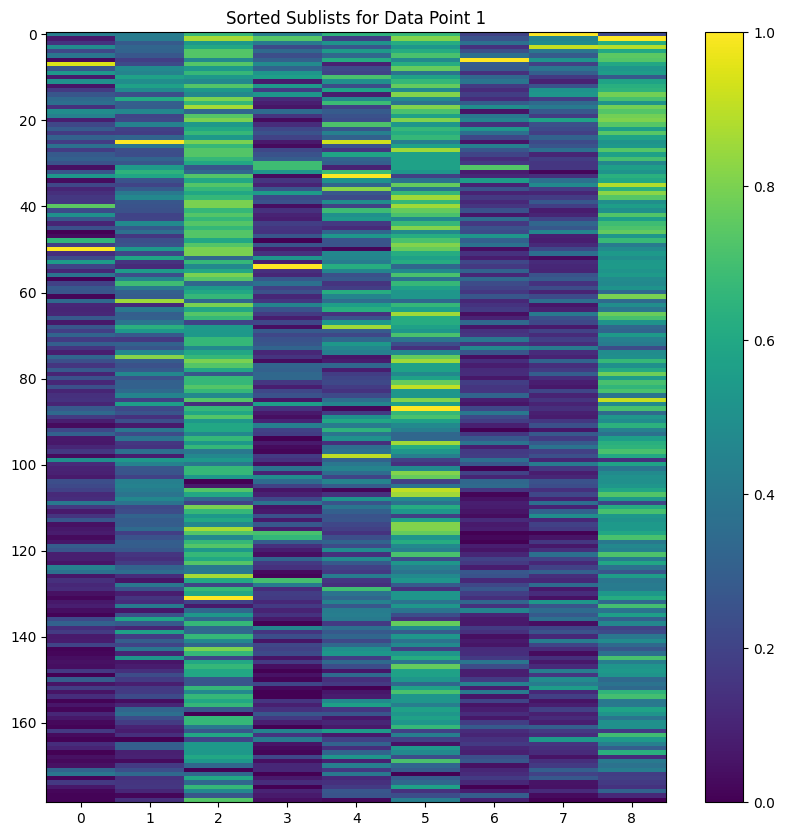

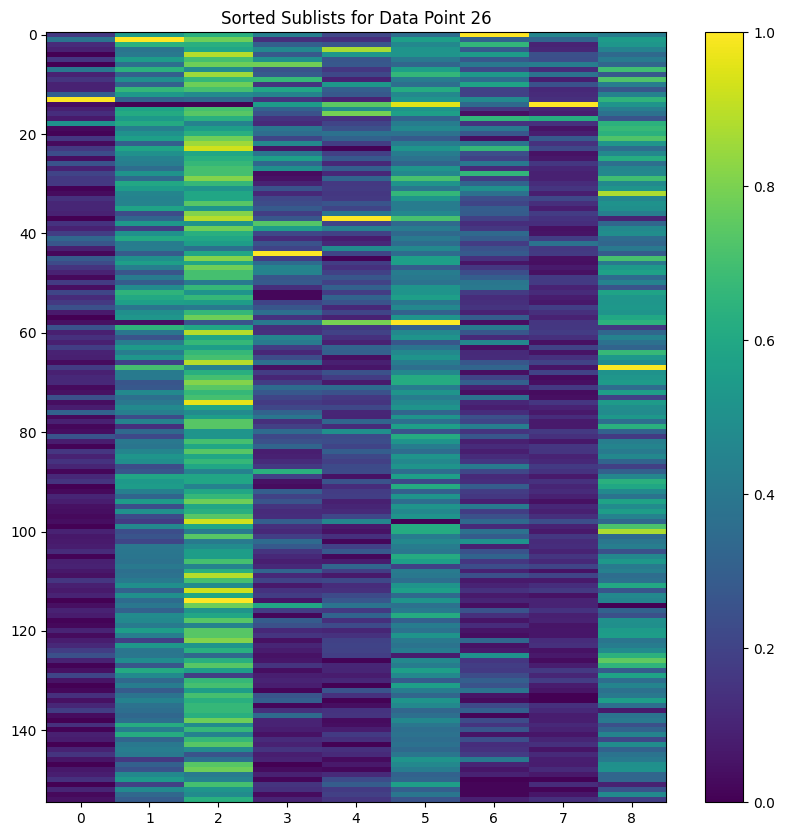

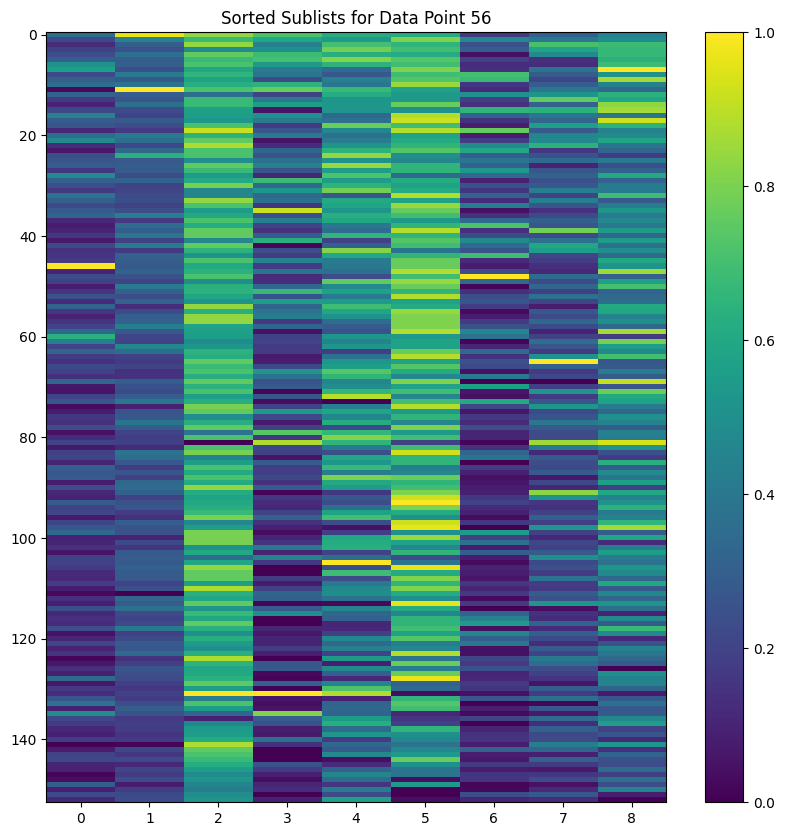

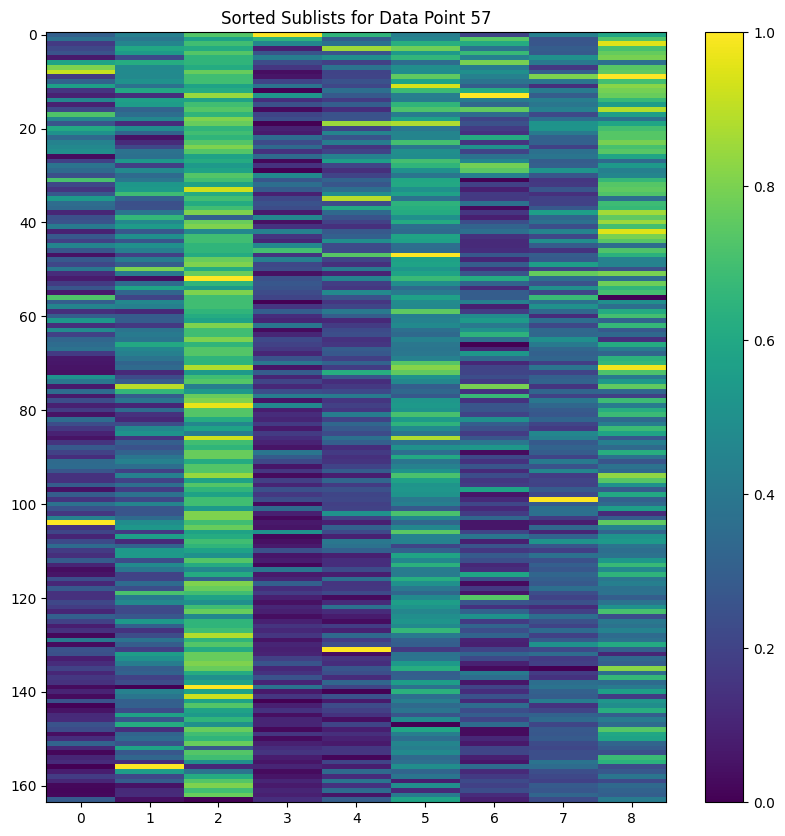

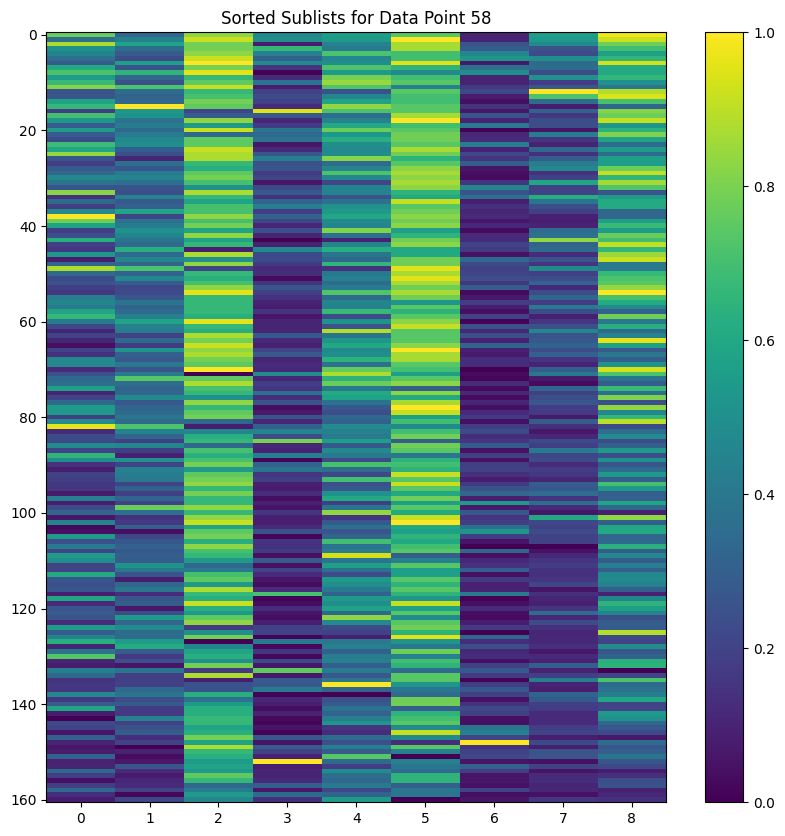

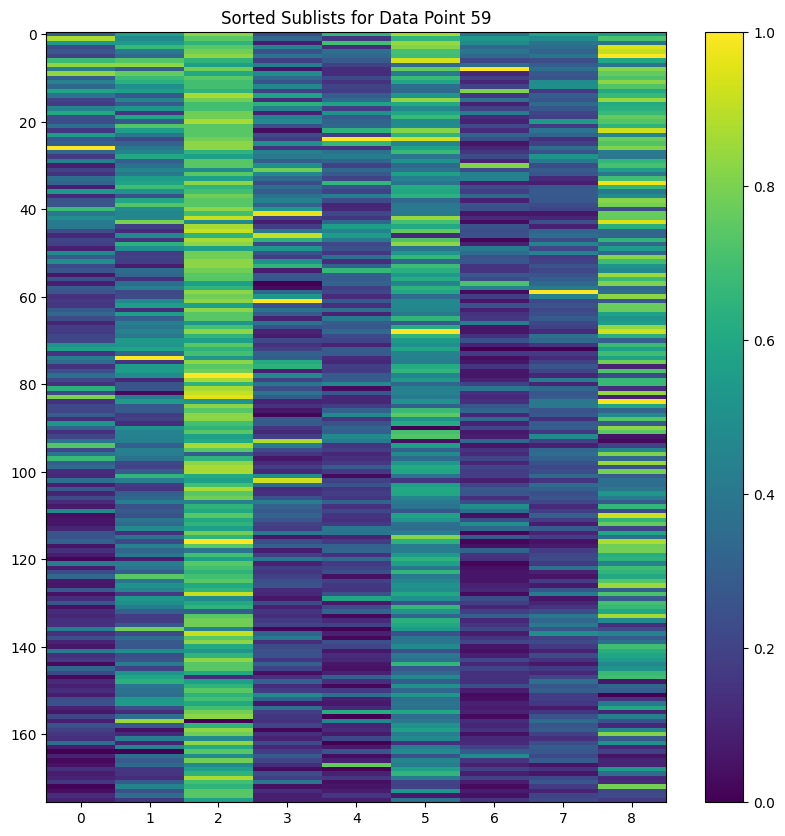

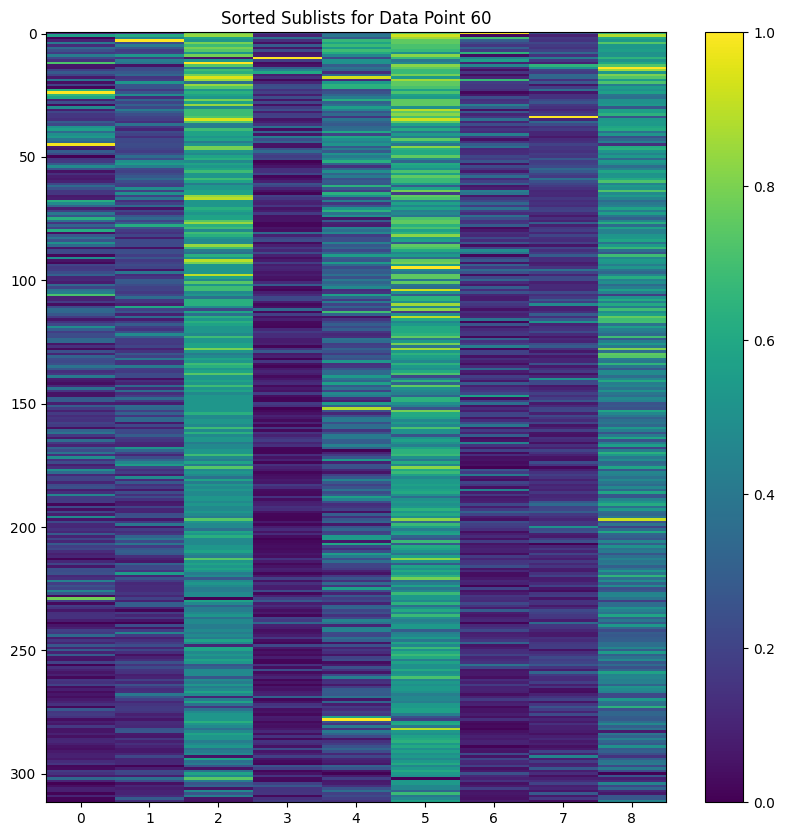

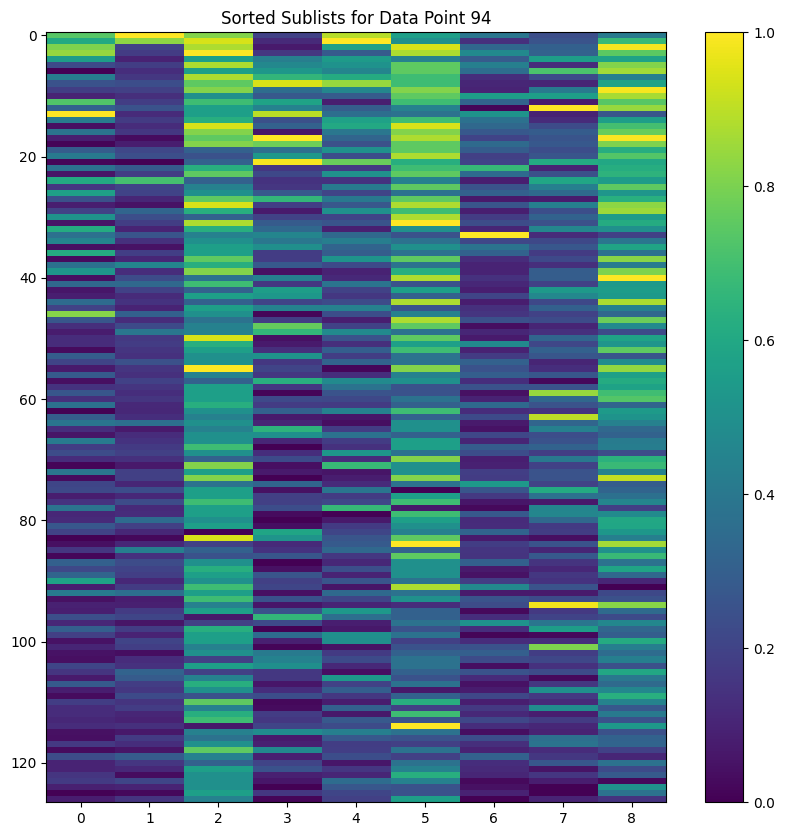

In [24]:
import numpy as np
import matplotlib.pyplot as plt

index_groups = [
    [0, 3, 6],  # Group 1
    [1, 4, 7],  # Group 2
    [2, 5, 8]   # Group 3
]

# Ideal row that represents "no anomaly"
ideal_row = np.array([0.5] * 9)

# Normalize, calculate anomaly scores, and sort the x-length lists (rows)
for i, dp in enumerate(datapoint_one[0:100]):  # Adjust range or dataset accordingly
    dp_array = np.array(dp)  # dp is the x-length list of length-9 sublists
    if len(dp_array)<100:
        continue
    # Normalization for each length-9 sublist
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    
    # Now calculate the anomaly score for each length-9 sublist
    anomaly_scores = []
    for row in dp_array:
        # Calculate Euclidean distance between each length-9 sublist and the ideal row
        anomaly_score = np.linalg.norm(row - ideal_row)
        anomaly_scores.append((anomaly_score, row))  # Store the score along with the sublist
    
    # Sort the x-length list (dp_array) based on anomaly scores
    sorted_rows = sorted(anomaly_scores, key=lambda x: x[0])

    # Extract the sorted sublists
    sorted_sublists = np.array([sublist for score, sublist in sorted_rows])

    # Visualize all sorted sublists as a combined heatmap
    plt.figure(figsize=(10, 10))  # Adjust figure size based on number of sublists
    plt.imshow(sorted_sublists, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Sorted Sublists for Data Point {i+1}')
    plt.colorbar()
    plt.show()


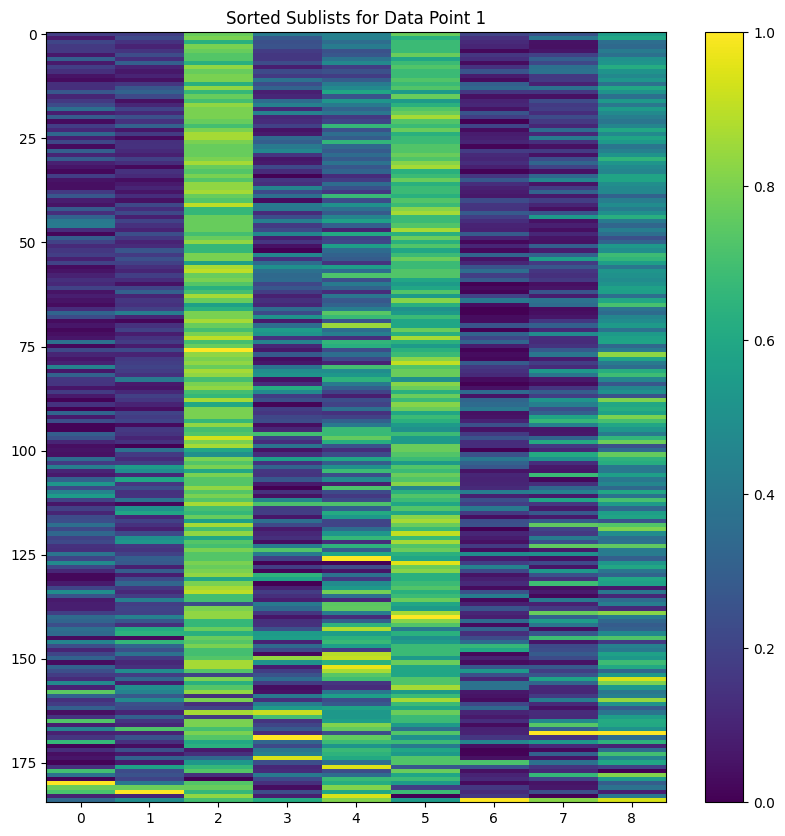

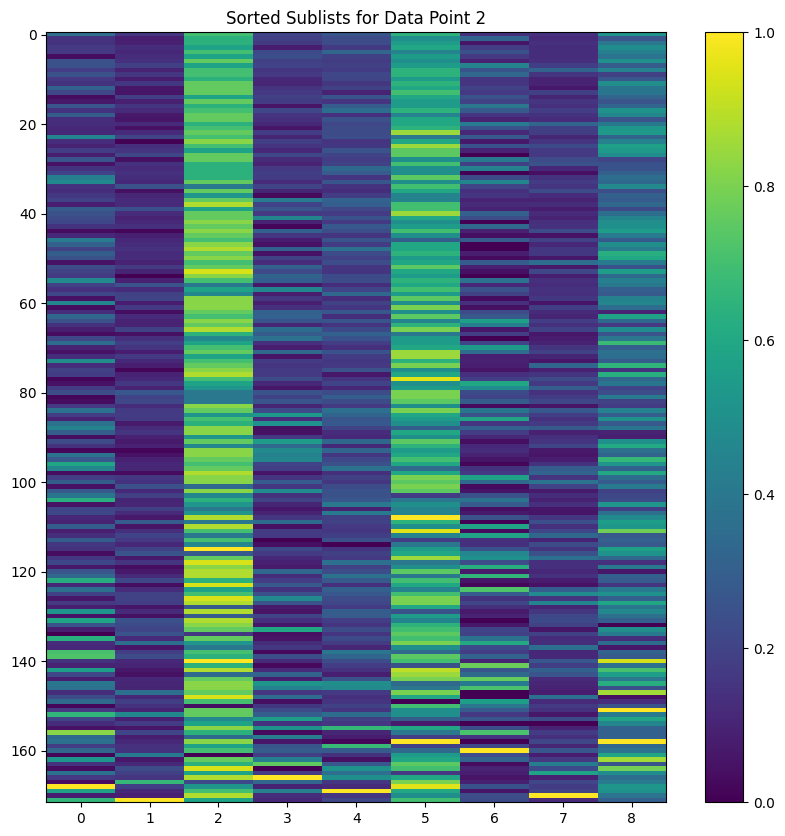

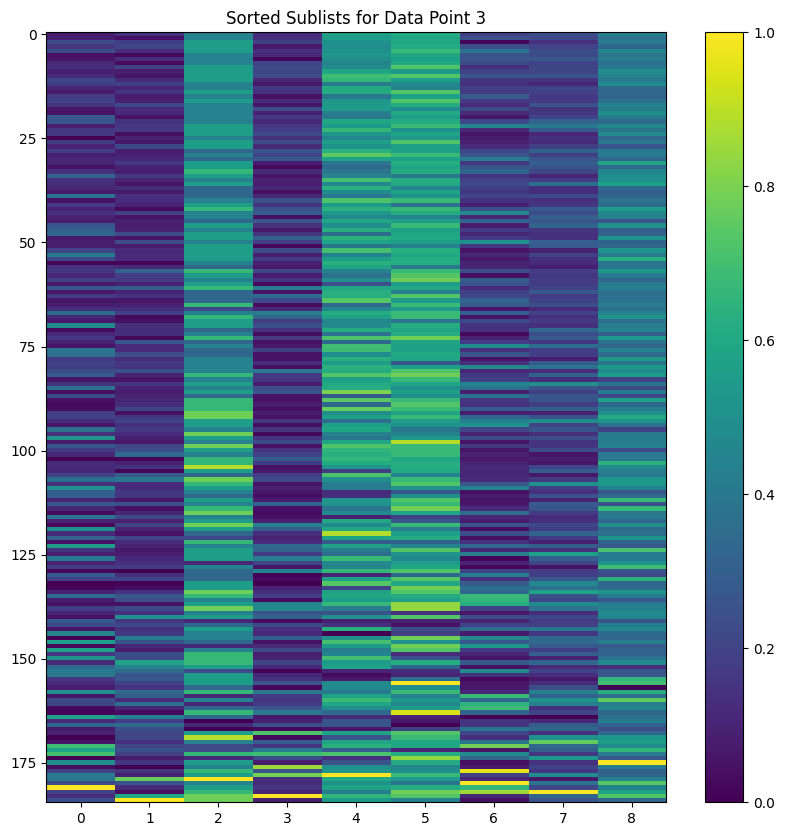

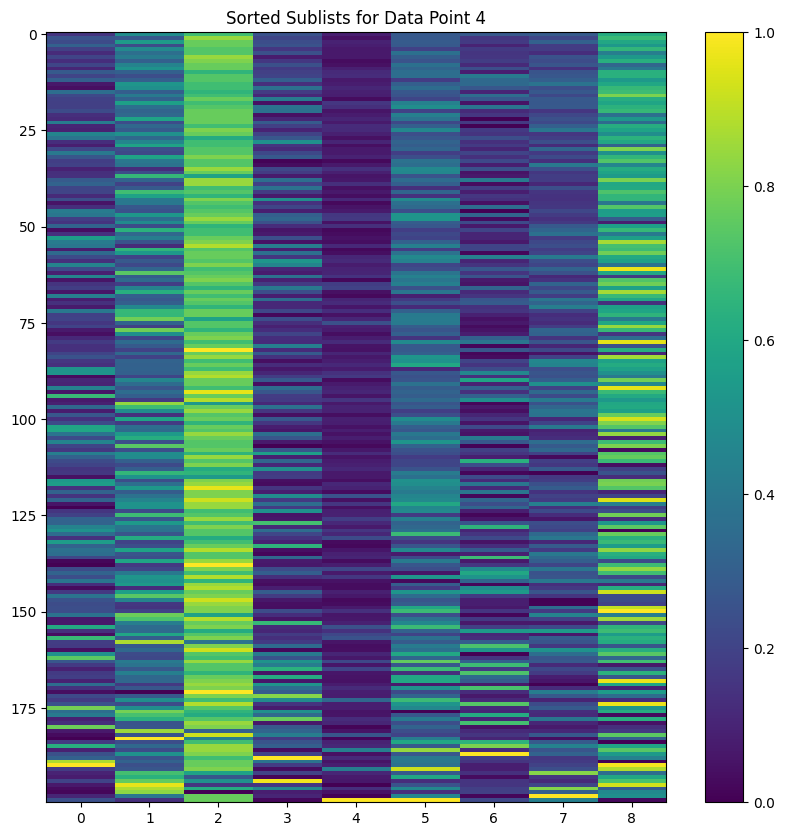

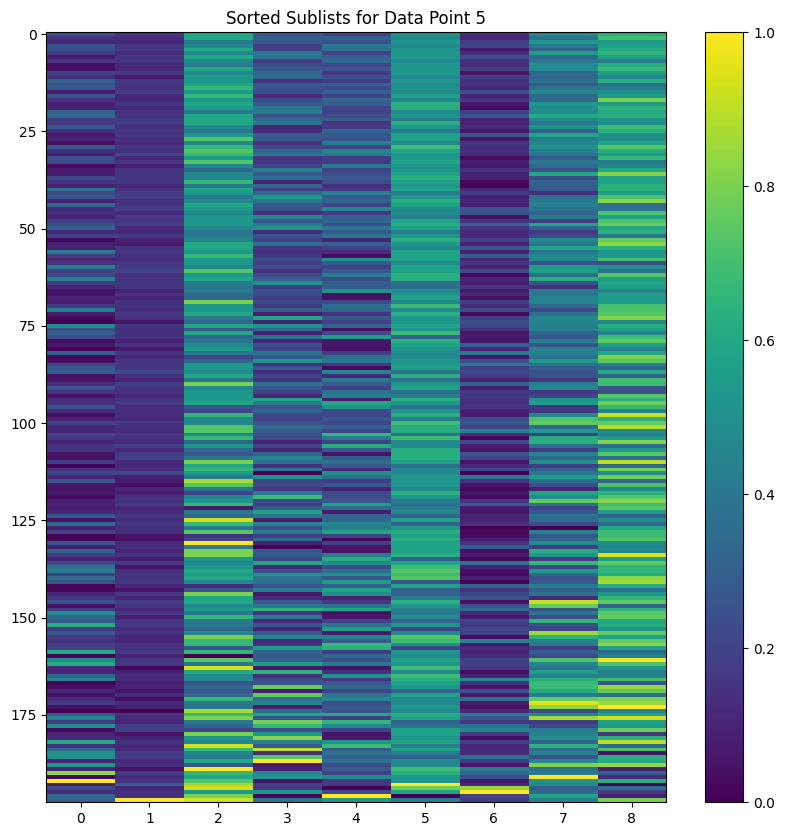

In [40]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Calculate Mahalanobis distance for each sublist instead of using Euclidean distance
for i, dp in enumerate(datapoint_zero[0:5]):  # Adjust range or dataset accordingly
    dp_array = np.array(dp)  # dp is the x-length list of length-9 sublists
    if len(dp_array) < 100:
        continue
    
    # Normalize data
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]

    # Calculate mean and inverse covariance matrix of the data
    mean = np.mean(dp_array, axis=0)
    cov_matrix = np.cov(dp_array, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Now calculate Mahalanobis distance-based anomaly score for each length-9 sublist
    anomaly_scores = []
    for row in dp_array:
        # Mahalanobis distance from the mean
        anomaly_score = mahalanobis(row, mean, inv_cov_matrix)
        anomaly_scores.append((anomaly_score, row))
    
    # Sort the x-length list (dp_array) based on anomaly scores
    sorted_rows = sorted(anomaly_scores, key=lambda x: x[0])

    # Extract the sorted sublists
    sorted_sublists = np.array([sublist for score, sublist in sorted_rows])

    # Visualize all sorted sublists as a combined heatmap
    plt.figure(figsize=(10, 10))  # Adjust figure size based on number of sublists
    plt.imshow(sorted_sublists, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Sorted Sublists for Data Point {i+1}')
    plt.colorbar()
    plt.show()


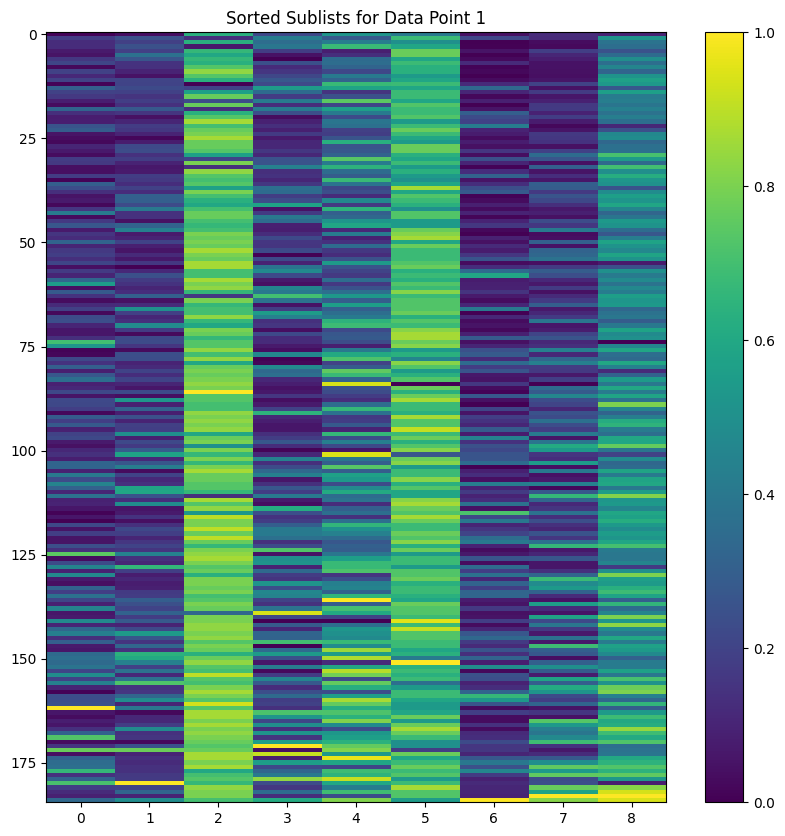

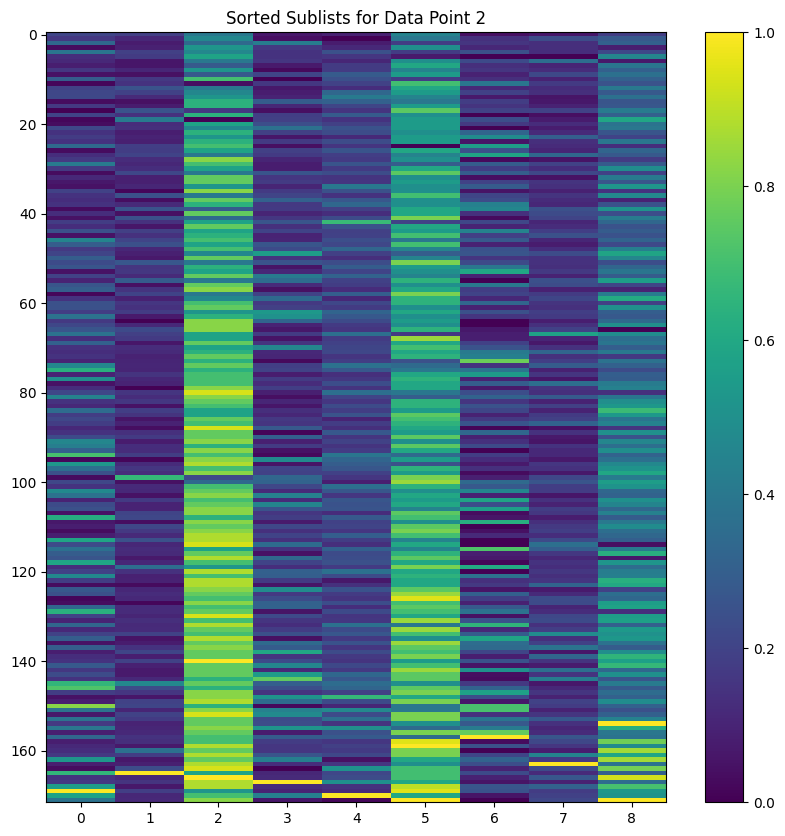

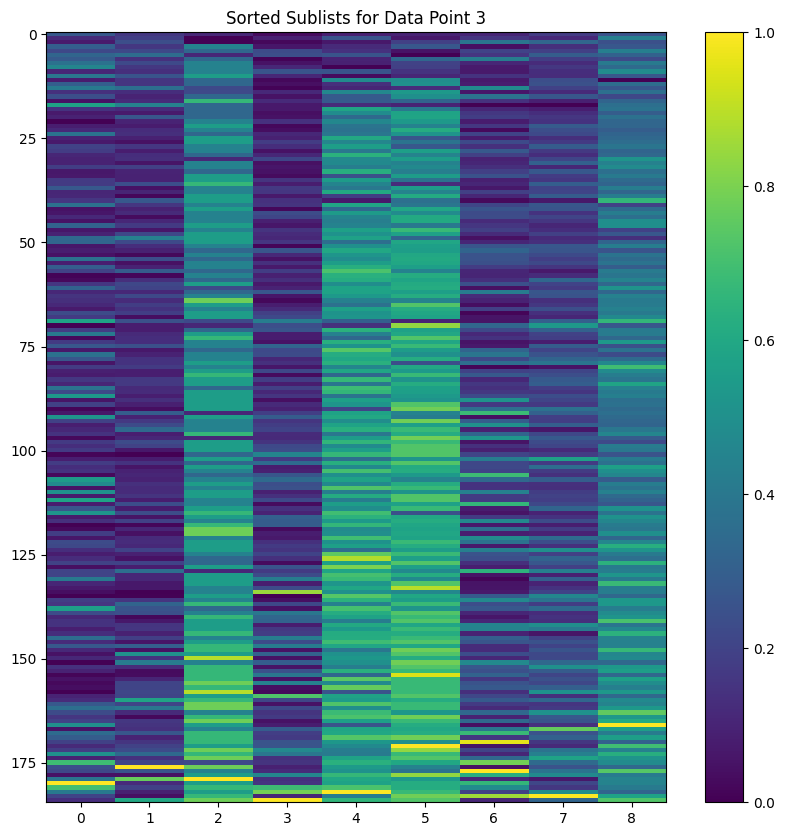

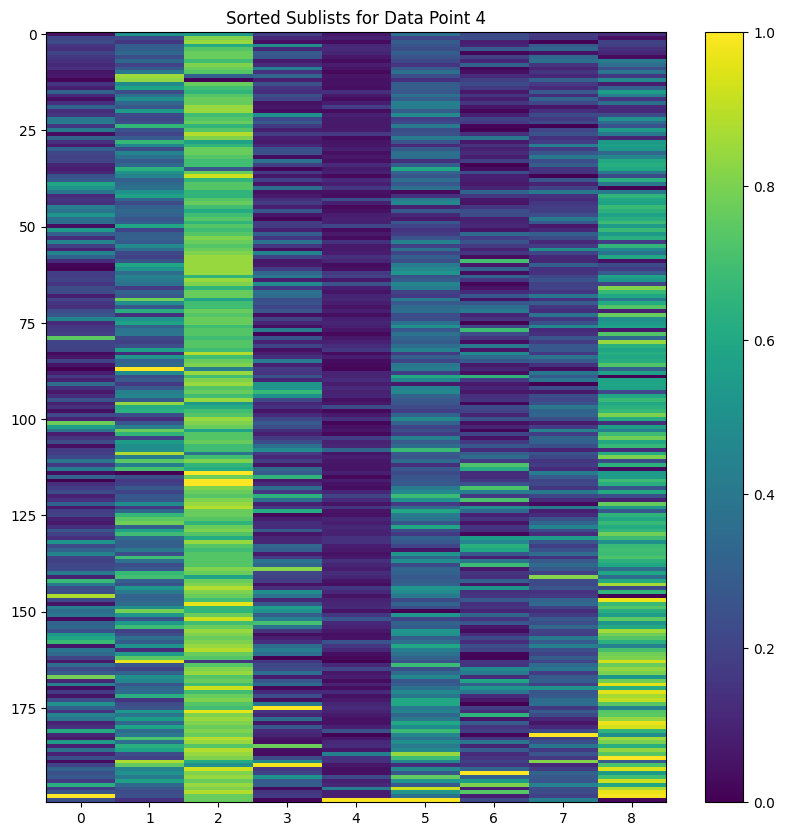

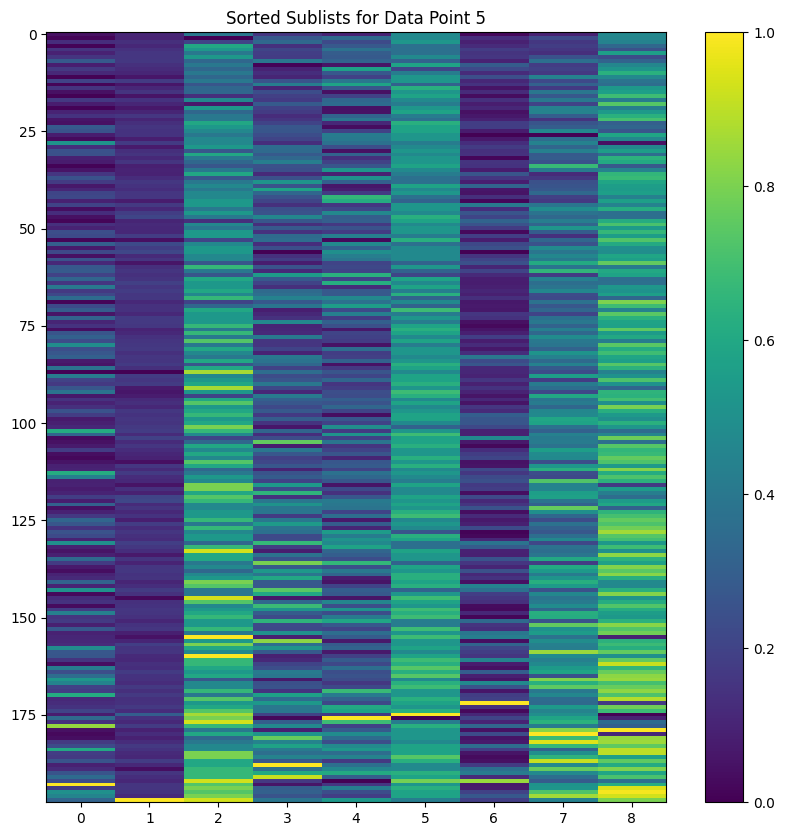

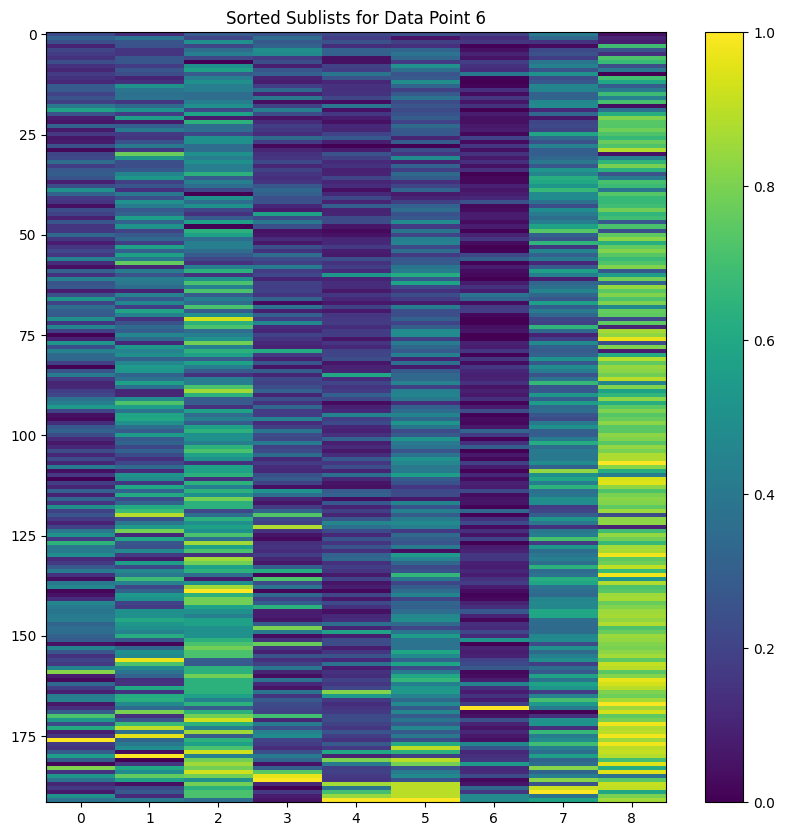

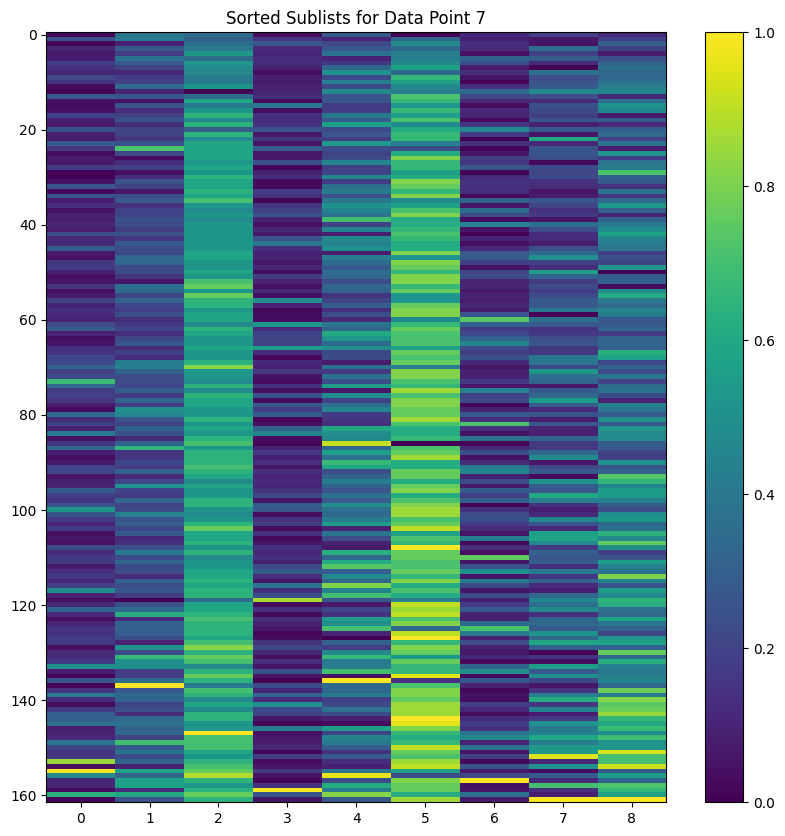

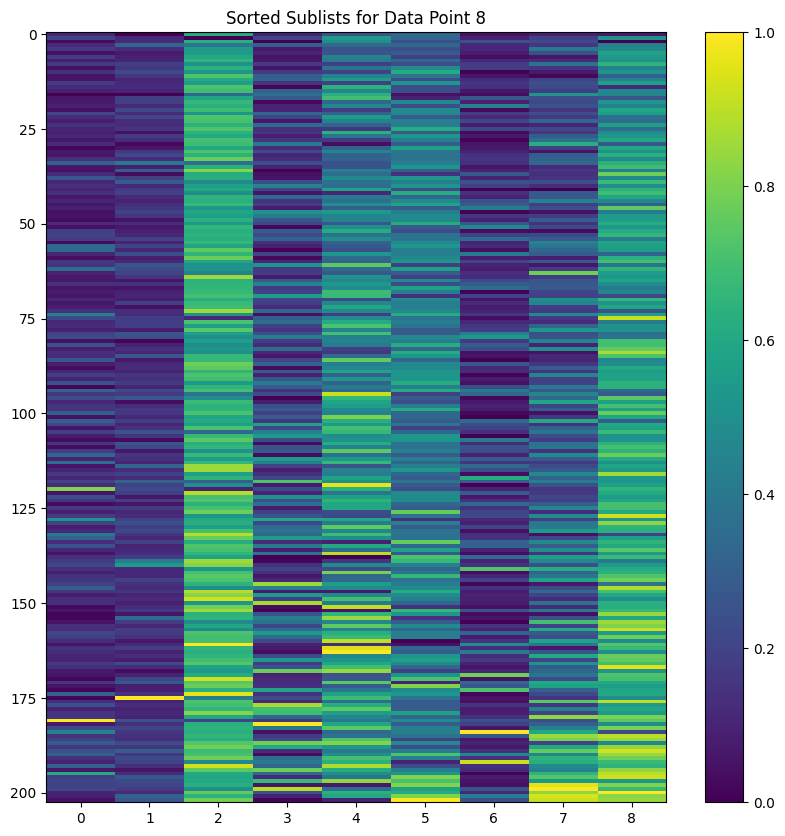

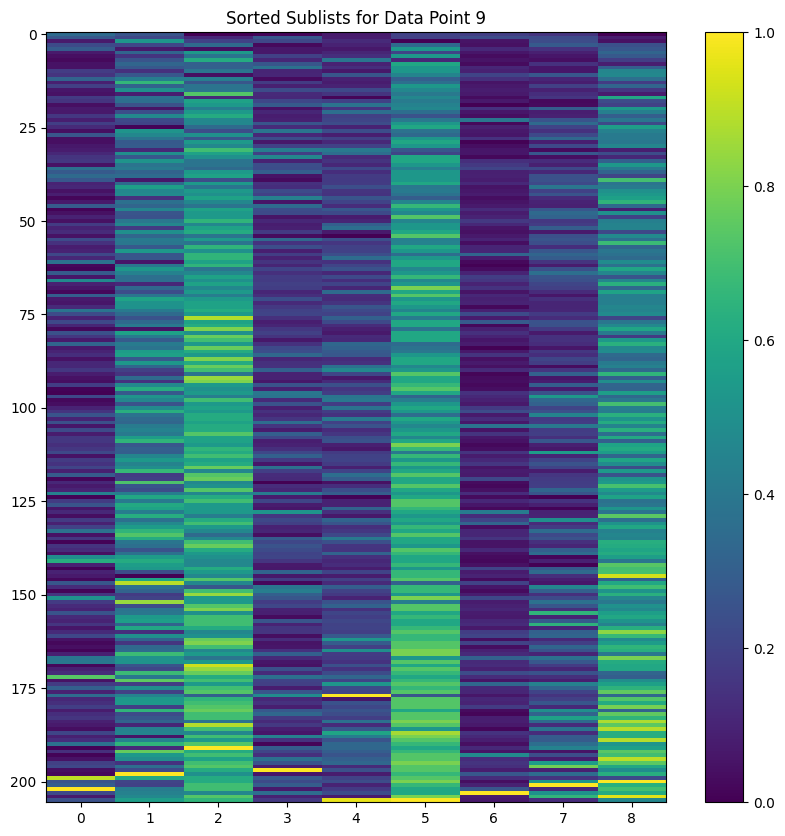

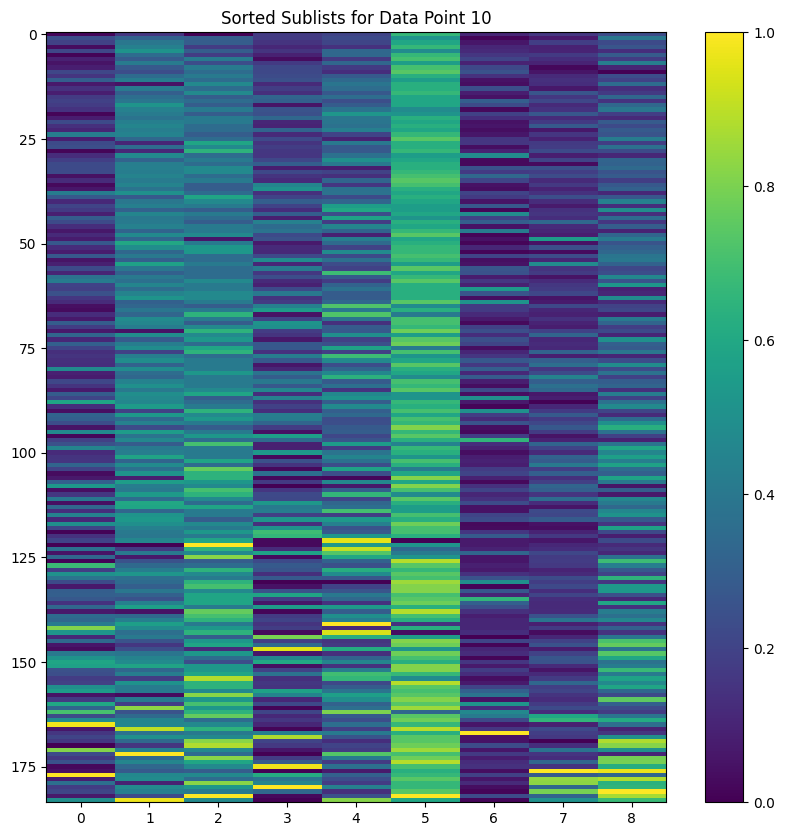

In [20]:
import numpy as np
import matplotlib.pyplot as plt

index_groups = [
    [0, 3, 6],  # Group 1
    [1, 4, 7],  # Group 2
    [2, 5, 8]   # Group 3
]

# Ideal row that represents "no anomaly"
ideal_row = np.array([0] * 9)

# Normalize, calculate anomaly scores, and sort the x-length lists (rows)
for i, dp in enumerate(datapoint_zero[0:10]):  # Adjust range or dataset accordingly
    dp_array = np.array(dp)  # dp is the x-length list of length-9 sublists
    
    # Normalization for each length-9 sublist
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    
    # Now calculate the anomaly score for each length-9 sublist
    anomaly_scores = []
    for row in dp_array:
        # Calculate Euclidean distance between each length-9 sublist and the ideal row
        anomaly_score = np.linalg.norm(row - ideal_row)
        anomaly_scores.append((anomaly_score, row))  # Store the score along with the sublist
    
    # Sort the x-length list (dp_array) based on anomaly scores
    sorted_rows = sorted(anomaly_scores, key=lambda x: x[0])

    # Extract the sorted sublists
    sorted_sublists = np.array([sublist for score, sublist in sorted_rows])

    # Visualize all sorted sublists as a combined heatmap
    plt.figure(figsize=(10, 10))  # Adjust figure size based on number of sublists
    plt.imshow(sorted_sublists, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Sorted Sublists for Data Point {i+1}')
    plt.colorbar()
    plt.show()


0


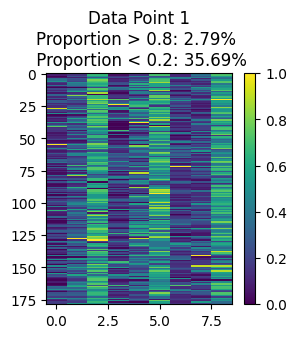

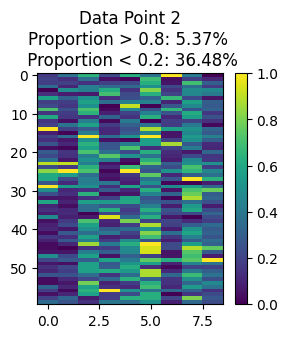

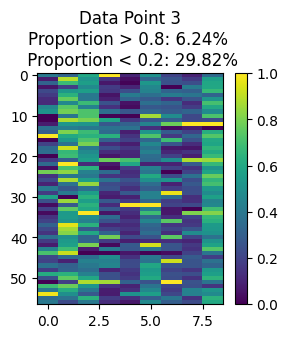

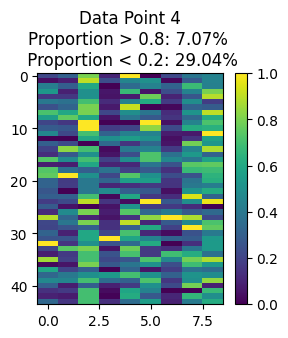

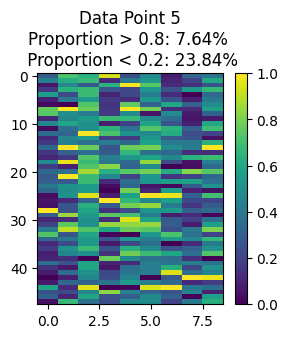

In [10]:
import matplotlib.pyplot as plt
index_groups = [
    [0, 3, 6],  # Group 1
    [1, 4, 7],  # Group 2
    [2, 5, 8]   # Group 3
]
# Plotting each data point as an image
normalized_data_one = []
for i, dp in enumerate(datapoint_one[0:5]):
    dp_array = np.array(dp)
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    normalized_dp = dp_array
    normalized_data_one.append(normalized_dp.flatten())
    if i%1000 == 0:
        print(i)
    # Counting values greater than 0.8
    count_high_values = np.sum(normalized_dp > 0.8)
    total_values = normalized_dp.size 
    proportion_high_values = count_high_values / total_values

    # Counting values lesser than 0.2
    count_low_values = np.sum(normalized_dp < 0.2)
    proportion_low_values = count_low_values / total_values

    plt.figure(figsize=(3, 3))  # Adjust figure size to your preference
    plt.imshow(normalized_dp, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Data Point {i+1}\nProportion > 0.8: {proportion_high_values:.2%} \n Proportion < 0.2: {proportion_low_values:.2%}')
    plt.colorbar()
    plt.show()

0


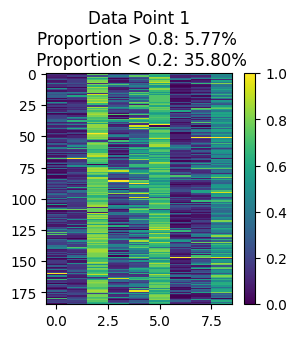

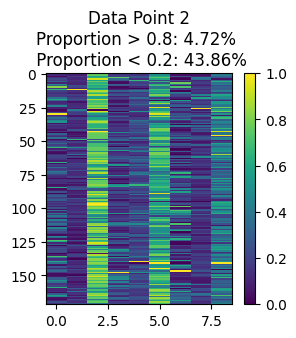

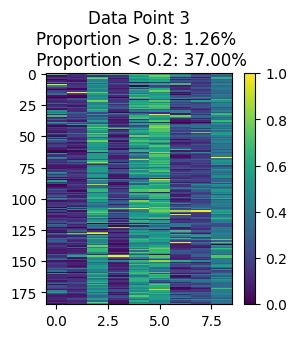

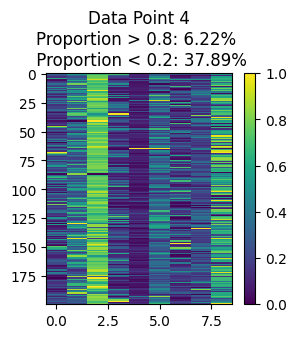

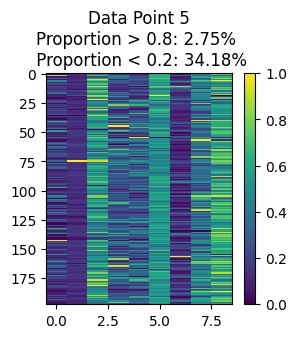

In [6]:
import matplotlib.pyplot as plt
index_groups = [
    [0, 3, 6],  # Group 1
    [1, 4, 7],  # Group 2
    [2, 5, 8]   # Group 3
]
# Plotting each data point as an image
normalized_data_zero = []
for i, dp in enumerate(datapoint_zero[0:5]):
    dp_array = np.array(dp)
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    normalized_dp = dp_array
    normalized_data_zero.append(normalized_dp.flatten())
    if i%1000 == 0:
        print(i)

    # Counting values greater than 0.8
    count_high_values = np.sum(normalized_dp > 0.8)
    total_values = normalized_dp.size 
    proportion_high_values = count_high_values / total_values

    # Counting values lesser than 0.2
    count_low_values = np.sum(normalized_dp < 0.2)
    proportion_low_values = count_low_values / total_values

    plt.figure(figsize=(3, 3))  # Adjust figure size to your preference
    plt.imshow(normalized_dp, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Data Point {i+1}\nProportion > 0.8: {proportion_high_values:.2%} \n Proportion < 0.2: {proportion_low_values:.2%}')
    plt.colorbar()
    plt.show()

In [116]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Combine and label the data
data = normalized_data_one + normalized_data_zero
labels = [1]*len(normalized_data_one) + [0]*len(normalized_data_zero)

# Pad data to the longest sequence
data_padded = pad_sequences(data, padding='post', dtype='float32', value=0.0)
print("Shape of data after padding:", data_padded.shape)
# Convert labels to a numpy array
labels = np.array(labels)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

sequence_length = 8919 // 9  

X_train = X_train.reshape(-1, sequence_length, 9)
X_test = X_test.reshape(-1, sequence_length, 9)


Shape of data after padding: (121838, 8919)


In [117]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(sequence_length, 9)),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=['accuracy', AUC(name='prc', curve='PR'), AUC(name='roc', curve='ROC')])
model.summary() 


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 989, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 494, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Number of features after padding:", data_padded.shape[-1])


Shape of X_train: (97470, 8919)
Shape of X_test: (24368, 8919)
Number of features after padding: 8919


In [118]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, class_weight=class_weights_dict)


Epoch 1/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7933 - loss: 0.6783 - prc: 0.0435 - roc: 0.5024 - val_accuracy: 0.9044 - val_loss: 0.6716 - val_prc: 0.0576 - val_roc: 0.5805
Epoch 2/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6712 - loss: 0.6860 - prc: 0.0523 - roc: 0.5474 - val_accuracy: 0.8080 - val_loss: 0.6467 - val_prc: 0.0626 - val_roc: 0.6082
Epoch 3/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6657 - loss: 0.6758 - prc: 0.0585 - roc: 0.5925 - val_accuracy: 0.6833 - val_loss: 0.6381 - val_prc: 0.0652 - val_roc: 0.6160
Epoch 4/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5809 - loss: 0.6745 - prc: 0.0660 - roc: 0.6172 - val_accuracy: 0.6049 - val_loss: 0.6606 - val_prc: 0.0668 - val_roc: 0.6196
Epoch 5/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5913 - loss: 0.6652 - prc: 0.0657 - roc: 0.6268 - val_accuracy: 0.5562 - val_loss: 0.6669 - val_prc: 0.0703 - val_roc: 0.6314
Epoch 6/10
2437/2437 ━━━━━━━━

In [120]:
test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5903 - loss: 0.6735 - prc: 0.1452 - roc: 0.7598


ValueError: too many values to unpack (expected 2)